In [1]:
import sys
sys.path.append("..")
%cd ..

c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021-1


In [68]:
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX
from Modelling import modelling
import matplotlib.pyplot as plt
from DataPrep.ImportData import importer
from DataPrep.LagCreation import lags
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pyforest
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = importer().Import()

In [4]:
def smape(A, F):
    return 100/len(A) * np.sum( np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [5]:
df2 = pd.DataFrame()

<IPython.core.display.Javascript object>

In [6]:
df = df.set_index("Start Date")
df.index = df.index.to_period("D")

In [7]:
idx = pd.period_range(df.index.min(),df.index.max())
for i in range(8): 
    dat = df[df["Label"]==float(i)].reindex(idx, fill_value=0)
    dat.Label = float(i)
    df2 = df2.append(dat)


<IPython.core.display.Javascript object>

In [8]:
df2 = df2.sort_index()
df2["Start Date"] = df2.index


In [9]:
int(df2[df2["Label"]==0.0].shape[0]*0.2)

614

In [10]:
y = df2[["Energy (kWh)","Start Date"]]

idx_train = int(df2[df2["Label"]==0.0].shape[0]*0.8*0.9)*8
idx_val = int(df2[df2["Label"]==0.0].shape[0]*0.8*0.1)*8
idx_test = (int(df2[df2["Label"]==0.0].shape[0]*0.2)+1)*8

#y= y.resample("d").min()
X = lags().buildLaggedFeatures(df2[["Energy (kWh)","Label"]], ["Energy (kWh)"],5, dropna=False)
X = X.drop(columns=["Energy (kWh)"])
X_train = X[0:idx_train].fillna(0)
X_val = X[idx_train:idx_train+idx_val].fillna(0)
X_test = X[idx_train+idx_val:idx_train+idx_val+idx_test].fillna(0)

y_train = y["Energy (kWh)"][0:idx_train]
y_val = y["Energy (kWh)"][idx_train:idx_train+idx_val]
y_test = y["Energy (kWh)"][idx_train+idx_val:idx_train+idx_val+idx_test]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=False)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42, shuffle=False)
#X_train=X_train.drop(columns="lag_0")
#X_test=X_test.drop(columns="lag_0")
#X_val=X_val.drop(columns="lag_0")


In [11]:
X_train

,Label,Energy (kWh)_lag1,Energy (kWh)_lag2,Energy (kWh)_lag3,Energy (kWh)_lag4,Energy (kWh)_lag5
2011-08-03,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2011-08-03,3.0,1.679882,0.000000,0.000000,0.000000,0.000000
2011-08-03,4.0,0.000000,1.679882,0.000000,0.000000,0.000000
2011-08-03,1.0,0.000000,0.000000,1.679882,0.000000,0.000000
2011-08-03,7.0,0.000000,0.000000,0.000000,1.679882,0.000000
...,...,...,...,...,...,...
2017-08-22,1.0,1.967917,2.668737,1.412125,2.280000,2.198714
2017-08-22,3.0,2.351610,1.967917,2.668737,1.412125,2.280000
2017-08-22,6.0,3.696192,2.351610,1.967917,2.668737,1.412125
2017-08-22,5.0,2.535821,3.696192,2.351610,1.967917,2.668737


In [12]:
X_train

,Label,Energy (kWh)_lag1,Energy (kWh)_lag2,Energy (kWh)_lag3,Energy (kWh)_lag4,Energy (kWh)_lag5
2011-08-03,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2011-08-03,3.0,1.679882,0.000000,0.000000,0.000000,0.000000
2011-08-03,4.0,0.000000,1.679882,0.000000,0.000000,0.000000
2011-08-03,1.0,0.000000,0.000000,1.679882,0.000000,0.000000
2011-08-03,7.0,0.000000,0.000000,0.000000,1.679882,0.000000
...,...,...,...,...,...,...
2017-08-22,1.0,1.967917,2.668737,1.412125,2.280000,2.198714
2017-08-22,3.0,2.351610,1.967917,2.668737,1.412125,2.280000
2017-08-22,6.0,3.696192,2.351610,1.967917,2.668737,1.412125
2017-08-22,5.0,2.535821,3.696192,2.351610,1.967917,2.668737


In [13]:
exog_train

NameError: name 'exog_train' is not defined

In [14]:
#exog = pd.DataFrame(columns=["Label 0","Label 1","Label 2","Label 3","Label 4","Label 5","Label 6","Label 7"])
exog = {"Label 0":pd.DataFrame(),"Label 1":pd.DataFrame(),"Label 2":pd.DataFrame(),"Label 3":pd.DataFrame(),"Label 4":pd.DataFrame(),"Label 5":pd.DataFrame(),"Label 6":pd.DataFrame(),"Label 7":pd.DataFrame()}
exog_v = {"Label 0":pd.DataFrame(),"Label 1":pd.DataFrame(),"Label 2":pd.DataFrame(),"Label 3":pd.DataFrame(),"Label 4":pd.DataFrame(),"Label 5":pd.DataFrame(),"Label 6":pd.DataFrame(),"Label 7":pd.DataFrame()}

for label in range(8):
    X_lags = pd.DataFrame(columns=["Lag 1", "Lag 2", "Lag 3", "Lag 4", "Lag 5"])
    X_lags_val = pd.DataFrame(columns=["Lag 1", "Lag 2", "Lag 3", "Lag 4", "Lag 5"])
    for lag in range(1,6):
        X_lags[f"Lag {lag}"] = (X_train[f"Energy (kWh)_lag{lag}"][X_train["Label"]==float(label)])
        X_lags_val[f"Lag {lag}"] = (X_val[f"Energy (kWh)_lag{lag}"][X_val["Label"]==float(label)])
    exog[f"Label {label}"] = X_lags
    exog_v[f"Label {label}"] = X_lags_val
#[X_train[X_train["Label"]==0.0],X_train[X_train["Label"]==1.0],X_train[X_train["Label"]==2.0],X_train[X_train["Label"]==3.0],X_train[X_train["Label"]==4.0],X_train[X_train["Label"]==5.0],X_train[X_train["Label"]==6.0],X_train[X_train["Label"]==7.0]]
exog_v

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'Label 0':                Lag 1     Lag 2     Lag 3     Lag 4     Lag 5
 2017-08-23  2.159529  2.914283  2.535821  3.696192  2.351610
 2017-08-24  2.436222  5.401143  2.065638  3.139091  2.778925
 2017-08-25  2.072815  3.221281  2.722620  2.658424  3.627815
 2017-08-26  2.992481  2.429843  2.038481  2.072815  3.221281
 2017-08-27  2.934319  1.719750  1.748548  5.158885  2.892500
 ...              ...       ...       ...       ...       ...
 2018-04-20  2.118741  2.689477  3.129743  4.072778  3.692188
 2018-04-21  2.897300  1.907533  2.147055  2.978455  1.608684
 2018-04-22  2.596929  5.958700  2.640484  3.480117  2.877510
 2018-04-23  3.088053  1.951258  2.596929  5.958700  2.640484
 2018-04-24  3.001784  2.140318  2.702585  3.625259  2.771655
 
 [245 rows x 5 columns],
 'Label 1':                Lag 1     Lag 2     Lag 3     Lag 4     Lag 5
 2017-08-23  1.954528  2.325967  2.367174  2.034890  2.159529
 2017-08-24  2.975676  3.843600  2.385278  2.720224  2.537548
 2017-08-25  2.658424

In [15]:
y_cols = pd.DataFrame(columns=["Label 0","Label 1","Label 2","Label 3","Label 4","Label 5","Label 6","Label 7"])
y_cols_val = pd.DataFrame(columns=["Label 0","Label 1","Label 2","Label 3","Label 4","Label 5","Label 6","Label 7"])
for i in range(8):
    y_cols[f"Label {i}"]=y_train[X_train["Label"]==float(i)]
    y_cols_val[f"Label {i}"]=y_val[X_val["Label"]==float(i)]

#[y_train[X_train["Label"]==0.0],y_train[X_train["Label"]==1.0],y_train[X_train["Label"]==2.0],y_train[X_train["Label"]==3.0],y_train[X_train["Label"]==4.0],y_train[X_train["Label"]==5.0],y_train[X_train["Label"]==6.0],y_train[X_train["Label"]==7.0]]
y_cols

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Label 0,Label 1,Label 2,Label 3,Label 4,Label 5,Label 6,Label 7
2011-08-03,1.679882,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-08-04,1.899242,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-08-05,1.574471,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-08-06,1.982032,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-08-07,2.232860,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2017-08-18,2.326522,2.834679,2.533874,3.570545,2.272300,2.943384,2.158226,5.232000
2017-08-19,1.687359,3.113306,2.646528,4.211074,2.189803,1.922590,2.315737,1.409333
2017-08-20,2.272558,2.287367,2.736587,2.996429,2.215360,3.114628,2.024920,1.907300
2017-08-21,2.224478,3.401296,3.233870,3.804053,2.827500,2.921962,2.198714,2.280000


In [16]:
exog[f"Label {1}"][f"Lag {1}"]

2011-08-03    0.000000
2011-08-04    0.000000
2011-08-05    0.000000
2011-08-06    0.000000
2011-08-07    0.000000
                ...   
2017-08-18    2.272300
2017-08-19    2.189803
2017-08-20    2.736587
2017-08-21    3.804053
2017-08-22    1.967917
Freq: D, Name: Lag 1, Length: 2212, dtype: float64

In [17]:
exog_train = pd.DataFrame(columns=["Lag 01","Lag 02","Lag 03","Lag 04","Lag 05","Lag 11","Lag 12","Lag 13","Lag 14","Lag 15","Lag 21","Lag 22","Lag 23","Lag 24","Lag 25","Lag 31","Lag 32","Lag 33","Lag 34","Lag 35","Lag 41","Lag 42","Lag 43","Lag 44","Lag 45","Lag 51","Lag 52","Lag 53","Lag 54","Lag 55","Lag 61","Lag 62","Lag 63","Lag 64","Lag 65","Lag 71","Lag 72","Lag 73","Lag 74","Lag 75"])
exog_val = pd.DataFrame(columns=["Lag 01","Lag 02","Lag 03","Lag 04","Lag 05","Lag 11","Lag 12","Lag 13","Lag 14","Lag 15","Lag 21","Lag 22","Lag 23","Lag 24","Lag 25","Lag 31","Lag 32","Lag 33","Lag 34","Lag 35","Lag 41","Lag 42","Lag 43","Lag 44","Lag 45","Lag 51","Lag 52","Lag 53","Lag 54","Lag 55","Lag 61","Lag 62","Lag 63","Lag 64","Lag 65","Lag 71","Lag 72","Lag 73","Lag 74","Lag 75"])
for label in range(8):
    for lag in range(1,6):
        exog_train[f"Lag {label}{lag}"] = exog[f"Label {label}"][f"Lag {lag}"]
        exog_val[f"Lag {label}{lag}"] = exog_v[f"Label {label}"][f"Lag {lag}"]

exog_val

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Lag 01,Lag 02,Lag 03,Lag 04,Lag 05,Lag 11,Lag 12,Lag 13,Lag 14,Lag 15,...,Lag 61,Lag 62,Lag 63,Lag 64,Lag 65,Lag 71,Lag 72,Lag 73,Lag 74,Lag 75
2017-08-23,2.159529,2.914283,2.535821,3.696192,2.351610,1.954528,2.325967,2.367174,2.034890,2.159529,...,2.367174,2.034890,2.159529,2.914283,2.535821,2.034890,2.159529,2.914283,2.535821,3.696192
2017-08-24,2.436222,5.401143,2.065638,3.139091,2.778925,2.975676,3.843600,2.385278,2.720224,2.537548,...,2.778925,2.909593,2.975676,3.843600,2.385278,2.909593,2.975676,3.843600,2.385278,2.720224
2017-08-25,2.072815,3.221281,2.722620,2.658424,3.627815,2.658424,3.627815,1.984244,2.895818,2.436222,...,2.895818,2.436222,5.401143,2.065638,3.139091,2.722620,2.658424,3.627815,1.984244,2.895818
2017-08-26,2.992481,2.429843,2.038481,2.072815,3.221281,2.429843,2.038481,2.072815,3.221281,2.722620,...,3.661340,4.309000,2.966964,1.657211,2.992481,2.966964,1.657211,2.992481,2.429843,2.038481
2017-08-27,2.934319,1.719750,1.748548,5.158885,2.892500,0.951364,2.224189,2.934319,1.719750,1.748548,...,5.158885,2.892500,3.463304,2.215729,2.252259,2.224189,2.934319,1.719750,1.748548,5.158885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-20,2.118741,2.689477,3.129743,4.072778,3.692188,2.656315,2.427509,2.835431,2.862634,2.594333,...,2.689477,3.129743,4.072778,3.692188,3.128771,3.454978,2.118741,2.689477,3.129743,4.072778
2018-04-21,2.897300,1.907533,2.147055,2.978455,1.608684,1.907533,2.147055,2.978455,1.608684,3.613481,...,1.608684,3.613481,4.181498,3.454978,2.118741,3.613481,4.181498,3.454978,2.118741,2.689477
2018-04-22,2.596929,5.958700,2.640484,3.480117,2.877510,3.539108,2.394387,2.897300,1.907533,2.147055,...,3.480117,2.877510,4.361808,2.863545,3.539108,2.640484,3.480117,2.877510,4.361808,2.863545
2018-04-23,3.088053,1.951258,2.596929,5.958700,2.640484,1.331250,4.549148,2.710289,2.651622,3.088053,...,2.651622,3.088053,1.951258,2.596929,5.958700,2.907655,1.331250,4.549148,2.710289,2.651622


In [36]:
exog_train[["Lag 01","Lag 02","Lag 03","Lag 04","Lag 05"]].shape[1]
#y_cols["Label 0"]
exog["Label 0"].shape

(2212, 5)

In [67]:
y_cols

,Label 0,Label 1,Label 2,Label 3,Label 4,Label 5,Label 6,Label 7
2011-08-03,1.679882,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-08-04,1.899242,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-08-05,1.574471,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-08-06,1.982032,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-08-07,2.232860,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2017-08-18,2.326522,2.834679,2.533874,3.570545,2.272300,2.943384,2.158226,5.232000
2017-08-19,1.687359,3.113306,2.646528,4.211074,2.189803,1.922590,2.315737,1.409333
2017-08-20,2.272558,2.287367,2.736587,2.996429,2.215360,3.114628,2.024920,1.907300
2017-08-21,2.224478,3.401296,3.233870,3.804053,2.827500,2.921962,2.198714,2.280000


In [108]:
mod = SARIMAX(y_cols["Label 0"][1900:],exog=y_cols[["Label 1","Label 2","Label 3","Label 4","Label 5","Label 6","Label 7"]][1900:], order=(7,0,5))
mod_fit = mod.fit()
mod_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Label 0   No. Observations:                  312
Model:               SARIMAX(7, 0, 5)   Log Likelihood                -212.589
Date:                Wed, 14 Apr 2021   AIC                            465.178
Time:                        14:36:59   BIC                            540.038
Sample:                    10-15-2016   HQIC                           495.097
                         - 08-22-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Label 1       -0.0046      0.073     -0.063      0.950      -0.147       0.138
Label 2        0.0668      0.096      0.692      0.489      -0.122       0.256
Label 3        0.1577      0.056      2.795      0.005       0.047       0.268
Label 4        0.2462      0.099      2.496      0.013       0.053       0.440
Label 5        0.1104      0.083      1.337      0.181      -0.051       0.272
Label 6        0.1542      0.092      1.673      0.094      -0.026       0.335
Label 7        0.1172      0.065      1.800      0.072      -0.010       0.245
ar.L1          0.6353      0.321      1.981      0.048       0.007       1.264
ar.L2         -0.4499      0.378     -1.189      0.234      -1.191       0.292
ar.L3          0.3415      0.381      0.897      0.370      -0.405       1.088
ar.L4          0.1232      0.364      0.339      0.735      -0.589       0.836
ar.L5         -0.1583      0.317     -0.500      0.617      -0.779       0.462
ar.L6         -0.1107      0.100     -1.107      0.268      -0.307       0.085
ar.L7          0.2004      0.095      2.108      0.035       0.014       0.387
ma.L1         -0.7543      0.327     -2.306      0.021      -1.396      -0.113
ma.L2          0.5619      0.401      1.400      0.161      -0.225       1.348
ma.L3         -0.2837      0.421     -0.673      0.501      -1.109       0.542
ma.L4         -0.2900      0.397     -0.730      0.466      -1.069       0.489
ma.L5          0.3523      0.318      1.107      0.269      -0.272       0.976
sigma2         0.2285      0.015     14.905      0.000       0.198       0.259
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11708.40
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                             3.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [110]:
y_pred = mod_fit.predict(start=y_val.index[0],end=y_val.index[100],exog=y_cols_val[["Label 1","Label 2","Label 3","Label 4","Label 5","Label 6","Label 7"]][y_val.index[0]:y_val.index[100]])  

y_pred.index=y_pred.index.to_timestamp()
y_pred


2017-08-23    2.375912
2017-08-24    2.695604
2017-08-25    2.252597
2017-08-26    2.621653
2017-08-27    2.150912
2017-08-28    2.304817
2017-08-29    2.284006
2017-08-30    2.270413
2017-08-31    2.213612
2017-09-01    2.357718
2017-09-02    2.130688
2017-09-03    2.313224
2017-09-04    2.906409
Freq: D, Name: predicted_mean, dtype: float64

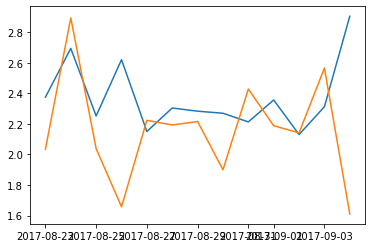

In [111]:
plt.plot(y_pred)
plt.plot(y_cols_val["Label 0"][:len(y_pred)])

In [63]:
mod = VARMAX(y_cols,order=(5,2), exog=exog_train)
mod_fit = mod.fit(maxlags=5)
mod_fit.summary()
#13000 (3,1)

Dep. Variable:,"['Label 0', 'Label 1', 'Label 2', 'Label 3', 'Label 4', 'Label 5', 'Label 6', 'Label 7']",No. Observations:,2212
Model:,"VARMAX(5,2)",Log Likelihood,-7947.891
,+ intercept,AIC,17519.782
Date:,"Tue, 13 Apr 2021",BIC,22149.524
Time:,18:38:06,HQIC,19211.073
Sample:,08-03-2011,,
,- 08-22-2017,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.00, 1.33, 0.23, 71.85, 1.86, 0.09, 4.86, 0.00",Jarque-Bera (JB):,"21984.51, 479.43, 473.18, 372.88, 1163.35, 782.05, 7274.44, 15975.99"
Prob(Q):,"1.00, 0.25, 0.63, 0.00, 0.17, 0.77, 0.03, 0.99",Prob(JB):,"0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"1.51, 0.45, 0.49, 2.33, 11.96, 6.38, 29.77, 37.49",Skew:,"1.53, 0.26, 0.03, 0.01, 0.25, -0.20, 0.34, -0.48"


In [64]:
y_pred = mod_fit.predict(start=y_val.index[0],end=y_val.index[-1],exog=exog_val)  

In [65]:
y_pred.index=y_pred.index.to_timestamp()
y_pred

,Label 0,Label 1,Label 2,Label 3,Label 4,Label 5,Label 6,Label 7
2017-08-23,2.161844,2.486283,2.395277,2.476204,1.700158,2.262496,1.964664,2.313359
2017-08-24,2.513350,3.720901,2.651452,5.565721,2.877069,3.921354,3.062595,3.371969
2017-08-25,2.244042,2.794052,2.309073,2.994049,1.779736,2.234528,1.760149,1.852139
2017-08-26,2.402787,3.272863,2.482356,3.871175,2.273714,3.033769,2.311823,2.670764
2017-08-27,2.396896,3.071244,2.250377,3.642115,1.800181,2.684508,2.135421,2.430220
...,...,...,...,...,...,...,...,...
2018-04-20,2.598476,3.177278,2.061015,4.524494,2.008588,3.022671,3.041198,3.570367
2018-04-21,2.516938,2.710243,1.928756,3.088645,1.415978,2.268348,2.471952,2.942788
2018-04-22,2.707721,3.782485,2.165740,6.066497,2.670202,4.015852,3.762691,4.316542
2018-04-23,2.400684,2.609072,1.894387,2.970672,1.263772,1.989255,2.224533,2.772008


Label 0


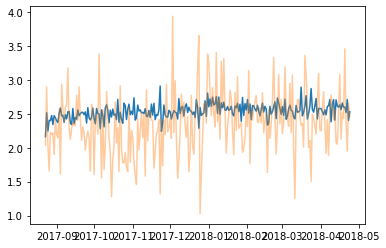

-0.13557412931096402
Label 1


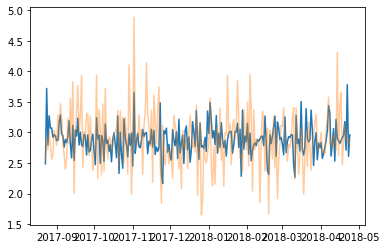

-0.07615264747961281
Label 2


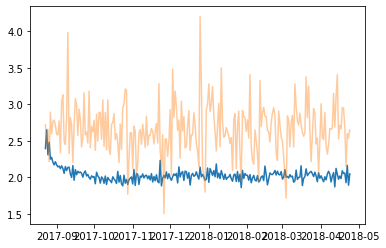

-3.235155351995032
Label 3


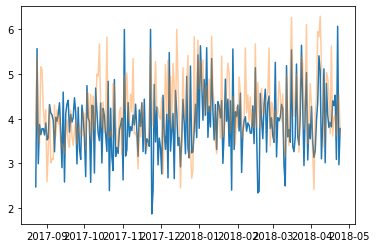

-0.5097704423458629
Label 4


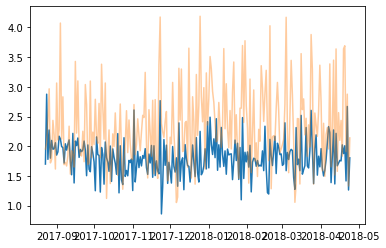

-0.5816922657287897
Label 5


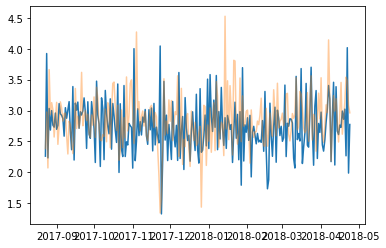

-0.6600705829134852
Label 6


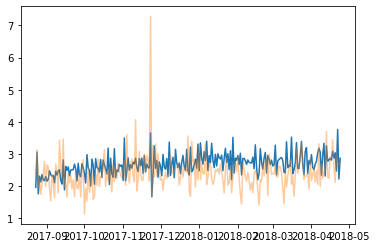

-0.3260503556532244
Label 7


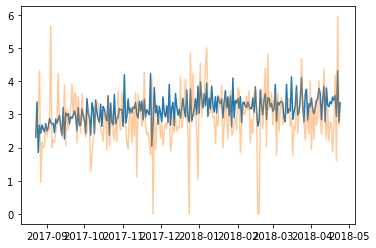

-0.0345667284574962


In [66]:
for i in range(8):
    print(f"Label {i}")
    plt.plot(y_pred[f"Label {i}"])
    plt.plot(y_cols_val[f"Label {i}"], alpha=0.4)
    plt.show() 
    print(r2_score(y_cols_val[f"Label {i}"],y_pred[f"Label {i}"]))
